In [7]:
import torch
import torch.nn as nn


from torchvision import transforms, datasets, models

import matplotlib.pyplot as plt
import numpy as np

from defenses.STRIP.STRIP import entropyCal
from trainModel import evaluate, custom_cv2_transform


from defense_CBD import DatasetBD

In [9]:
class Opt:
    def __init__(self):

        self.dataset = 'ImageNet'
        self.cam_maps_address = './data/cam_maps.csv'
        self.trigger_type = 'camouflageTriggerCircle'
        self.target_type = 'all2one'

        self.target_label = 2
        
        self.batch_size = 64
                
        self.trig_w = 3
        self.trig_h = 3
        self.input_height = 224
        self.input_width = 224


In [10]:
opt = Opt()

In [11]:
tf_train = transforms.Compose([
    transforms.Lambda(custom_cv2_transform),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [12]:
trainset = datasets.ImageFolder('./data/ImageNet/train')
testset = datasets.ImageFolder('./data/ImageNet/val')

In [13]:
train_data_clean = DatasetBD(opt, full_dataset=trainset, inject_portion=0, transform=tf_train, mode='train')
# train_data_bad = DatasetBD(opt, full_dataset=trainset, inject_portion=0.01, transform=tf_train, mode='train')

test_data_clean = DatasetBD(opt, full_dataset=testset, inject_portion=0, transform=tf_train, mode='test')
test_data_bad = DatasetBD(opt, full_dataset=testset, inject_portion=1, transform=tf_train, mode='test')

Generating trainbad Imgs


100%|██████████| 13000/13000 [02:53<00:00, 74.72it/s] 


Injecting Over: 0Bad Imgs, 13000Clean Imgs
Generating testbad Imgs


100%|██████████| 500/500 [00:06<00:00, 81.52it/s] 


Injecting Over: 0Bad Imgs, 500Clean Imgs
Generating testbad Imgs


100%|██████████| 500/500 [00:06<00:00, 75.56it/s] 

Injecting Over: 450Bad Imgs, 50Clean Imgs


In [15]:
train_model = torch.load('./saved_models/resnet18-whole_model-imagenet10.pth')

device = torch.device("cuda")
train_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [46]:
n_test = 400
n_sample = 20
entropy_benign = [0] * n_test
entropy_trojan = [0] * n_test


for j in range(n_test):
    x_background, _, __ = test_data_clean[j]
    entropy_benign[j] = entropyCal(x_background, n_sample, train_model, train_data_clean)

    
for j in range(n_test):
    x_poison, _, __ = test_data_bad[j]
    entropy_trojan[j] = entropyCal(x_poison, n_sample, train_model, train_data_clean)

entropy_benign = [x / n_sample for x in entropy_benign]
entropy_trojan = [x / n_sample for x in entropy_trojan]

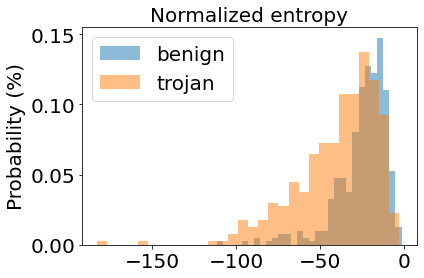

In [47]:
bins = 30
plt.hist(entropy_benign, bins, weights=np.ones(len(entropy_benign)) / len(entropy_benign), alpha=0.5, label='benign')
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=0.5, label='trojan')
plt.legend(loc='upper left', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('Normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()

fig1.savefig('./logs/STRIP/EntropyTrojanAndBenign.png')